# Victoria Metrics

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import read_dot, graphviz_layout

import utilities.stats as stats
import utilities.graphs as graphs
import utilities.sqlite_helper as helper

In [2]:
# Needs to be done when there are changes in these files ...
import importlib
importlib.reload(helper)
importlib.reload(stats)
importlib.reload(graphs)
print("Updates imports")

Updates imports


In [72]:
# CONSTANTS
NON_PROJECT_NODES = ["runtime", "testing"]

TODOS:
[] Failed benchmarks also need to be removed from full graph
[] remove split thing everywhere

#### Helpers

In [3]:
def get_name_from_dot(path):
    # Remove last dot, remove last 3 "_" which are hardcoded
    return path.split("/")[-1].rsplit(".", 1)[0].rsplit("_", 3)[0]

def get_name_from_db_bench(name):
    return name.replace("/", "-")

In [4]:
def change(rl: float, ru: float):
    if ru < 1:
        return (1-ru) * 100
    elif rl > 1:
        return (rl-1) * 100
    else:
        return 0

In [5]:
# Hierachical Bootstrap
def boostrap_ratio_mean_laaber(benchmark: dict, num_iterations: int=10000):
    bootstrap_mean = []
    for _ in range(num_iterations):
        samples = []
        trials = list(benchmark.keys())
        for _ in trials:
            # Pick random trial
            random_trial = np.random.choice(trials, replace=True)
            iterations = list(benchmark[random_trial])
            
            for _ in iterations:
                # Pick random iteration
                random_iteration_idx = np.random.choice(len(iterations), replace=True)
                ns = iterations[random_iteration_idx][2]
                samples.append(ns)

        bootstrap_mean.append(np.mean(samples))  
    return bootstrap_mean          


# Loading Data for instability

In [40]:
db_path_tags = "/Users/christopher/Uni/MasterThesis/exp7vcitoria/exp7victoria/sqlite-database.db"

In [41]:
measurements = helper.get_all_measurements(db_path_tags, start_form_count=0)

# group by tag/version
grouped_by_tag = helper.group_measurements_by_property(measurements, -2)

# group by benchmark name
for tag in grouped_by_tag.keys():
    grouped_by_tag[tag] = helper.group_measurements_by_property(grouped_by_tag[tag], -3)

v1.89.0 BenchmarkSetHasHitRandomLastBits/lastBits_28 0.6802182915746167
v1.89.0 BenchmarkMapHasHitRandomLastBits/lastBits_32 0.5281200733323842
v1.89.0 BenchmarkSetHasHitRandomLastBits/lastBits_20 1.5448311730200015
v1.89.0 BenchmarkRowsUnmarshal 0.8675993697510348
v1.89.0 BenchmarkSetHasHitRandomLastBits/lastBits_32 1.0009678829085884
v1.89.0 BenchmarkMapHasHitRandomLastBits/lastBits_28 0.7440170852793558
v1.89.0 BenchmarkHeadPostingForMatchers/n="1",i=~".+",i!~"2.*",j="foo" 0.5791547890241965
v1.89.0 BenchmarkHeadPostingForMatchers/n="1",i=~".+",i!="2",j="foo" 0.6092098011390488
v1.89.0 BenchmarkSetHasHitRandomLastBits/lastBits_24 1.1304046952315279
v1.89.0 BenchmarkHeadPostingForMatchers/n="1",j!="foo" 0.5195120892073789
v1.89.0 BenchmarkHeadPostingForMatchers/i=~".*" 0.616276185556814
v1.89.0 BenchmarkHeadPostingForMatchers/n="1",i=~".+",j="foo" 0.58083922422006
v1.89.0 BenchmarkHeadPostingForMatchers/n="1",i=~".*",i!="2",j="foo" 0.9078822914876125
v1.89.0 BenchmarkHeadPostingForMa

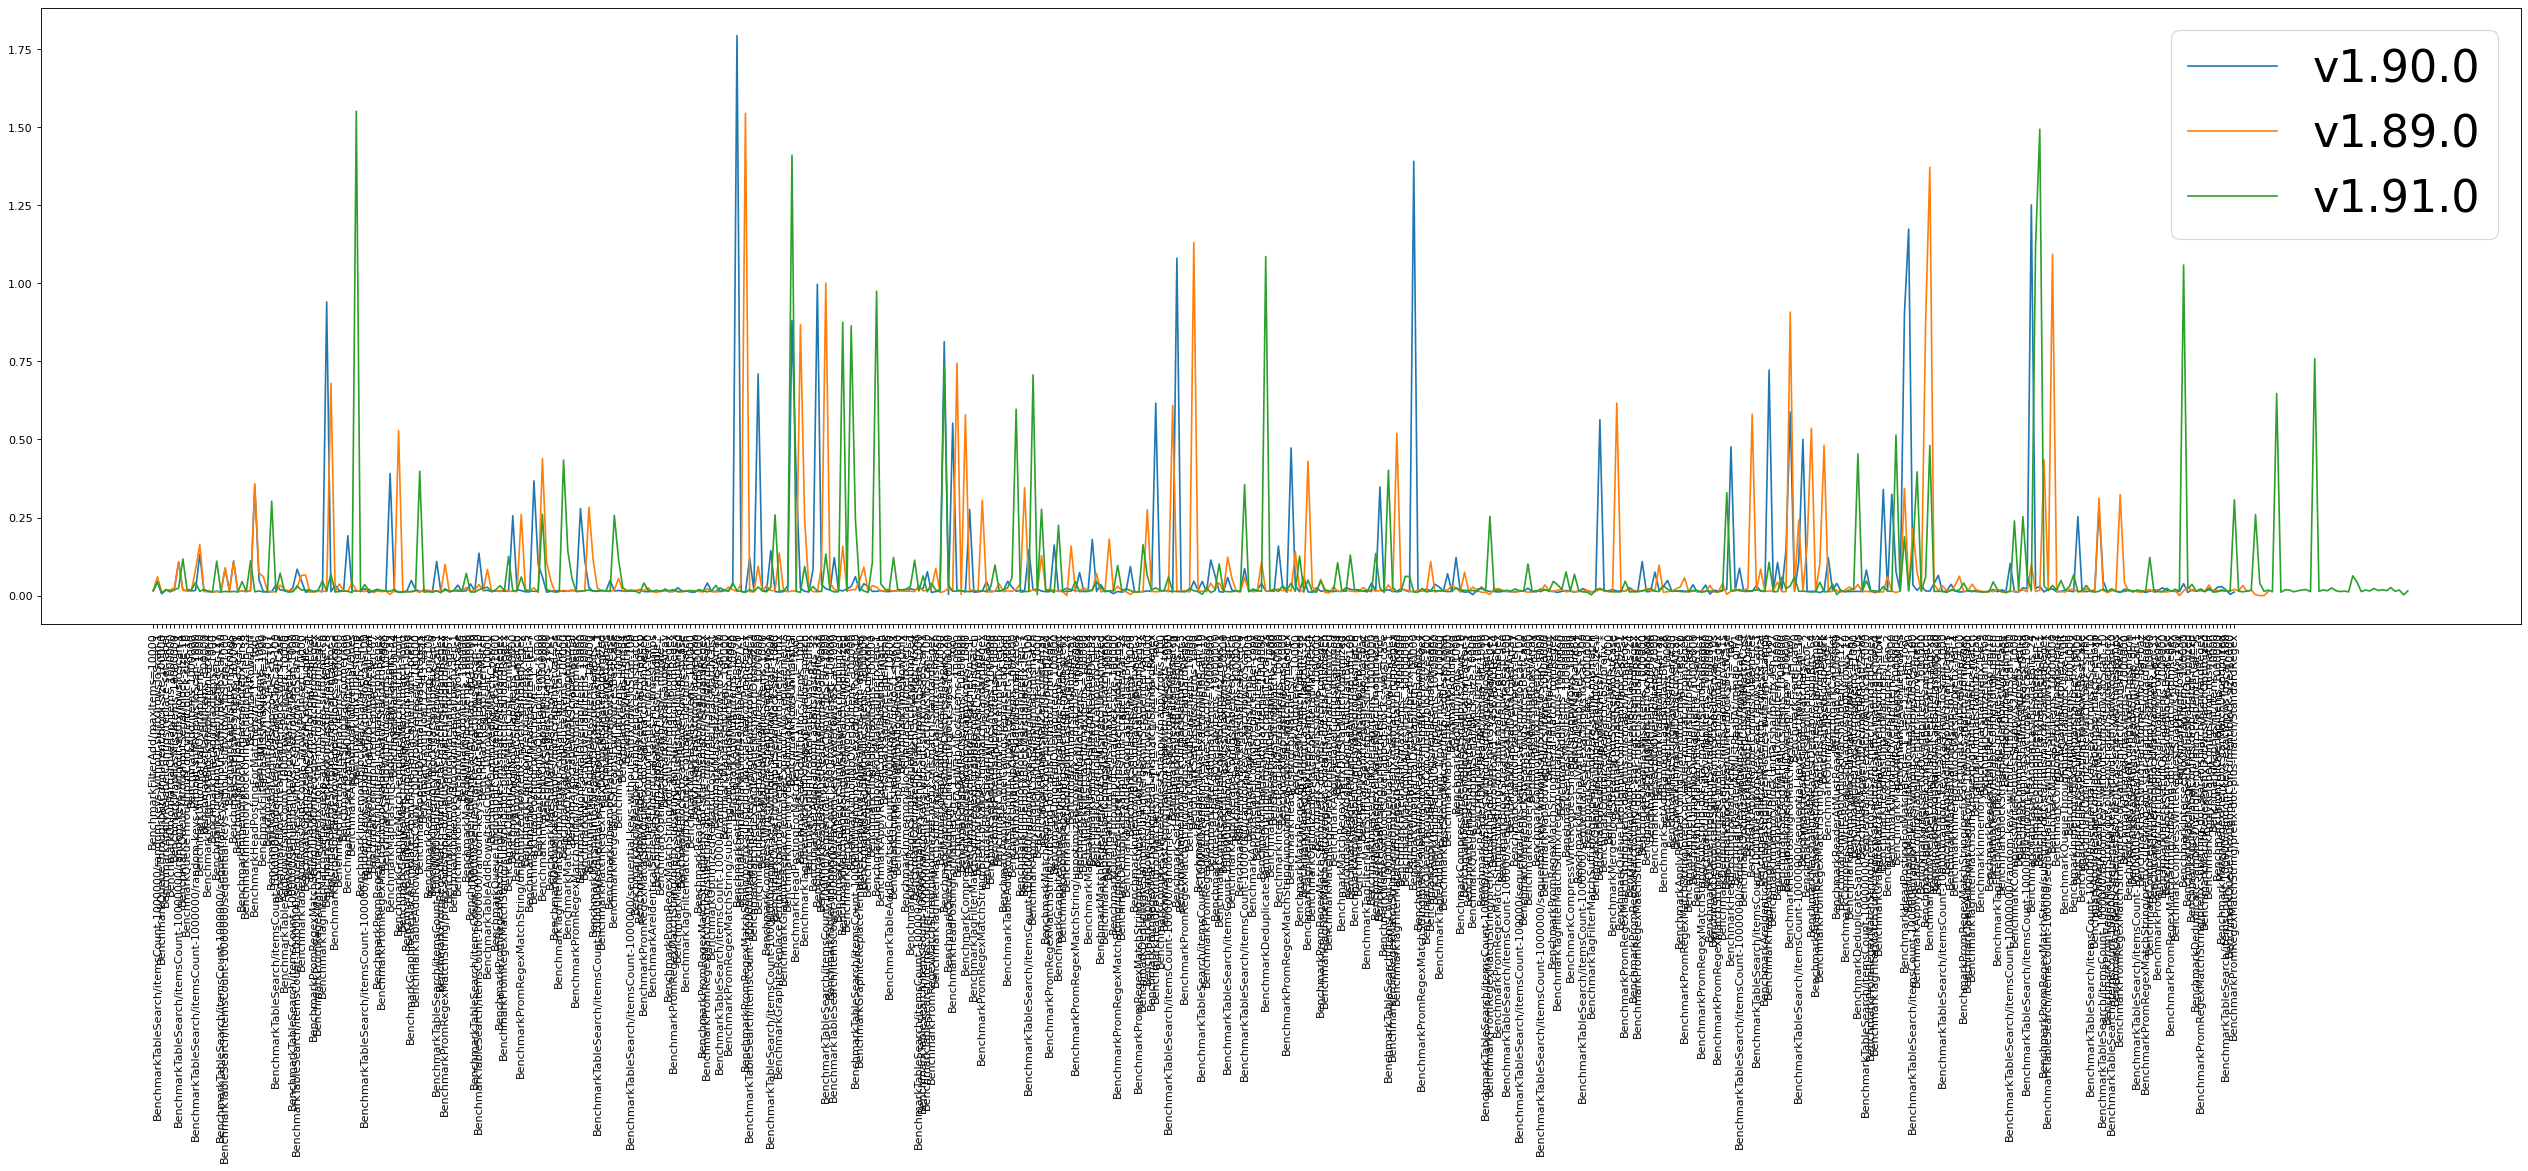

In [42]:
unstable_benchmarks = []
stability_measures = {}

plt.figure(figsize=(40, 10), dpi=80)

labels=list(next(iter(grouped_by_tag.values())).keys())
plt.xticks([x for x in range(len(labels))], labels, rotation='vertical')

for tag in grouped_by_tag.keys():
    cv = []
    spread = []
    for bench in grouped_by_tag[tag].keys():
        x = []
        measurments = grouped_by_tag[tag][bench]
        for entry in measurments:
            x.append(entry[2])
        current_cv = stats.cv(x)
        cv.append(current_cv)
        try:
            stability_measures[get_name_from_db_bench(bench)].append(current_cv)
        except KeyError:
            stability_measures[get_name_from_db_bench(bench)] = [current_cv]

        if (current_cv) > 0.5 and tag == "v1.89.0":
            print(f"{tag} {bench} {current_cv}")
            unstable_benchmarks.append(get_name_from_db_bench(bench))
        spread.append(stats.max_spread(x))

    plt.plot(cv, label=tag)
plt.legend(fontsize="40")
plt.show()

# Calculate Performance Changes

In [43]:
# group by trial
for tag in grouped_by_tag.keys():
    for bench in grouped_by_tag[tag].keys():
        grouped_by_tag[tag][bench] = helper.group_measurements_by_property(grouped_by_tag[tag][bench], -5)

In [47]:
# Increase to 10000
changes = []
for bench in list(grouped_by_tag['v1.89.0'].keys()):
    try:
        b_mean_old = boostrap_ratio_mean_laaber(grouped_by_tag['v1.89.0'][bench], 1000)
        b_mean_new = boostrap_ratio_mean_laaber(grouped_by_tag['v1.90.0'][bench], 1000)

        R_B = []
        for i in range(len(b_mean_old)):
            R_B.append(b_mean_new[i] / b_mean_old[i])


        cl = 0.99
        lower_percentile = (1 - cl) / 2
        upper_percentile = 1 - lower_percentile
        lower_bound = np.percentile(R_B, lower_percentile * 100)
        upper_bound = np.percentile(R_B, upper_percentile * 100)
        performance_change = change(lower_bound, upper_bound)
        changes.append(performance_change)
    except KeyError:
        print(f"Benchmark '{bench}' was removed in newer version")

Benchmark 'BenchmarkAggregatorsPushByJobAvg/output=total' was removed in newer version
Benchmark 'BenchmarkAggregatorsPushByJobAvg/output=stdvar' was removed in newer version
Benchmark 'BenchmarkAggregatorsPushByJobAvg/output=max' was removed in newer version
Benchmark 'BenchmarkAggregatorsPushByJobAvg/output=last' was removed in newer version
Benchmark 'BenchmarkAggregatorsPushByJobAvg/output=sum_samples' was removed in newer version
Benchmark 'BenchmarkAggregatorsPushByJobAvg/output=quantiles(0,_0.5,_1)' was removed in newer version
Benchmark 'BenchmarkAggregatorsPushByJobAvg/output=increase' was removed in newer version
Benchmark 'BenchmarkAggregatorsPushByJobAvg/output=histogram_bucket' was removed in newer version


In [49]:
perf_dict = {}
for idx, x in enumerate(changes):
    if x <= 0:
        continue
    name = list(grouped_by_tag['v1.89.0'].keys())[idx]
    name = get_name_from_db_bench(name)
    perf_dict[name] = x

In [53]:
len(perf_dict.keys())

108

# Load Graph Data

In [54]:
graph_paths0 = "/Users/christopher/Uni/MasterThesis/exp7vcitoria/exp7victoria/backup-mt-1-instance-0/"
graph_paths1 = "/Users/christopher/Uni/MasterThesis/exp7vcitoria/exp7victoria/backup-mt-1-instance-1/"

In [73]:
dot_files = []
for graph_paths in [graph_paths0, graph_paths1]:
    # Convert files to dot files for further analysis

    # Clear existing dot files
    for existingDotFile in glob.glob(graph_paths + "*.dot"):
        os.remove(existingDotFile)

    if len(glob.glob(graph_paths + "*.dot")) == 0:
        files = glob.glob(graph_paths + "*")
        for file in files:
            
            if file.endswith(".dot"):
                continue
            
            name = file.split(".out")[0]
            command = f"go tool pprof -nodecount=10000 --nodefraction=0.0 --edgefraction=0.0 -dot '{name}.out' > '{name}.dot'"
            stream = os.popen(command)
            output = stream.read()
            

    dot_files.extend(glob.glob(graph_paths + "*.dot"))

/Users/christopher/Uni/MasterThesis/exp7vcitoria/exp7victoria/backup-mt-1-instance-0/07-14-2023_BenchmarkSetHasHitRandomLastBits-lastBits_28_1_1_v1-89-0.out: parsing profile: empty input file
failed to fetch any source profiles
/Users/christopher/Uni/MasterThesis/exp7vcitoria/exp7victoria/backup-mt-1-instance-0/07-11-2023_backup-mt-1-instance-0-log.txt.out: open /Users/christopher/Uni/MasterThesis/exp7vcitoria/exp7victoria/backup-mt-1-instance-0/07-11-2023_backup-mt-1-instance-0-log.txt.out: no such file or directory
failed to fetch any source profiles
/Users/christopher/Uni/MasterThesis/exp7vcitoria/exp7victoria/backup-mt-1-instance-0/07-14-2023_backup-mt-1-instance-0-log.txt.out: open /Users/christopher/Uni/MasterThesis/exp7vcitoria/exp7victoria/backup-mt-1-instance-0/07-14-2023_backup-mt-1-instance-0-log.txt.out: no such file or directory
failed to fetch any source profiles
/Users/christopher/Uni/MasterThesis/exp7vcitoria/exp7victoria/backup-mt-1-instance-1/07-14-2023_BenchmarkSetHa

In [74]:
"""Load and convert all graphs, and generate a unique node mapping."""
count_bad_input = 0
ordered_graphs = {}
none_perf_benchs = []
removed_node_name = set()
for dot_file in dot_files:
    name = get_name_from_dot(dot_file)

    if "BenchmarkSize" in name or "BenchmarkMemory" in name:
        none_perf_benchs.append(name)
        continue
    
    try:
        curr_graph = read_dot(dot_file)
        curr_graph = graphs.convertWeigthsToFloat(curr_graph)
    except ValueError: 
        count_bad_input += 1
        print(dot_file.split("/")[-1])
        continue
    
    # Check if one of the nodes includes 'runActualBenchmark, if yes create a subgraph starting at that node
    nodes_to_remove = []
    for node in curr_graph.nodes(data=True):
        if  node[1]['label'] not in NON_PROJECT_NODES:   #.startswith('victoria'):
            continue
        nodes_to_remove.append(node[0])
    curr_graph.remove_nodes_from(nodes_to_remove)

    # Add all graphs from the same benchmark together and later form the union
    try: 
        ordered_graphs[name].append(curr_graph)
    except KeyError:
       ordered_graphs[name] = []
       ordered_graphs[name].append(curr_graph)


print(f"Bad input: {count_bad_input}")
print(f"None perf benchmarks: {none_perf_benchs}")
print(f"Removed node names: {removed_node_name}")

07-14-2023_BenchmarkSetHasHitRandomLastBits-lastBits_28_1_1_v1-89-0.dot
07-14-2023_backup-mt-1-instance-0-log.txt.dot
07-11-2023_backup-mt-1-instance-0-log.txt.dot
07-14-2023_backup-mt-1-instance-1-log.txt.dot
07-14-2023_BenchmarkSetHasHitRandomLastBits-lastBits_24_1_1_v1-89-0.dot
Bad input: 5
None perf benchmarks: []
Removed node names: set()


In [75]:
all_graphs = [val for sublist in ordered_graphs.values() for val in sublist]
nameMappingFull = graphs.generateUniqueNodeMapping(all_graphs)

ERROR: ['File: regexutil.test\\lType: cpu\\lTime: Jul 14, 2023 at 6:28pm (CEST)\\lDuration: 9.65s, Total samples = 9490ms (98.33%)\\lShowing nodes accounting for 9490ms, 100% of 9490ms total\\l\\lSee https://git.io/JfYMW for how to read the graph\\l']
ERROR: ['File: regexutil.test\\lType: cpu\\lTime: Jul 14, 2023 at 4:19pm (CEST)\\lDuration: 11.26s, Total samples = 11.10s (98.58%)\\lShowing nodes accounting for 11.10s, 100% of 11.10s total\\l\\lSee https://git.io/JfYMW for how to read the graph\\l']
ERROR: ['File: mergeset.test\\lBuild ID: e1763ac63dcb449faed459fb8fbb4d864f6a9b39\\lType: cpu\\lTime: Jul 14, 2023 at 7:04pm (CEST)\\lDuration: 44.78s, Total samples = 44.62s (99.64%)\\lShowing nodes accounting for 44.62s, 100% of 44.62s total\\l\\lSee https://git.io/JfYMW for how to read the graph\\l']
ERROR: ['File: mergeset.test\\lBuild ID: e1763ac63dcb449faed459fb8fbb4d864f6a9b39\\lType: cpu\\lTime: Jul 14, 2023 at 4:21pm (CEST)\\lDuration: 49.35s, Total samples = 49.05s (99.39%)\\lShow

In [77]:
final_graphs = []
for keys in ordered_graphs.keys():
    #
    if len(ordered_graphs[keys]) != 2:
        print(keys, len(ordered_graphs[keys]))

    union_graphs = []
    for graph in ordered_graphs[keys]:
        mapping = graphs.getNodeNameMapping(graph)
        
        nodeMapping = {}
        # get node name by value
        for key in mapping:
            nodeMapping[key] = nameMappingFull[mapping[key]]

        union_graphs.append(nx.relabel_nodes(graph, nodeMapping))

    final_graphs.append(nx.compose_all(union_graphs))

ERROR: ['File: regexutil.test\\lType: cpu\\lTime: Jul 14, 2023 at 6:28pm (CEST)\\lDuration: 9.65s, Total samples = 9490ms (98.33%)\\lShowing nodes accounting for 9490ms, 100% of 9490ms total\\l\\lSee https://git.io/JfYMW for how to read the graph\\l']
ERROR: ['File: regexutil.test\\lType: cpu\\lTime: Jul 14, 2023 at 4:19pm (CEST)\\lDuration: 11.26s, Total samples = 11.10s (98.58%)\\lShowing nodes accounting for 11.10s, 100% of 11.10s total\\l\\lSee https://git.io/JfYMW for how to read the graph\\l']
ERROR: ['File: mergeset.test\\lBuild ID: e1763ac63dcb449faed459fb8fbb4d864f6a9b39\\lType: cpu\\lTime: Jul 14, 2023 at 7:04pm (CEST)\\lDuration: 44.78s, Total samples = 44.62s (99.64%)\\lShowing nodes accounting for 44.62s, 100% of 44.62s total\\l\\lSee https://git.io/JfYMW for how to read the graph\\l']
ERROR: ['File: mergeset.test\\lBuild ID: e1763ac63dcb449faed459fb8fbb4d864f6a9b39\\lType: cpu\\lTime: Jul 14, 2023 at 4:21pm (CEST)\\lDuration: 49.35s, Total samples = 49.05s (99.39%)\\lShow

In [78]:
print(f"Number of graphs: {len(final_graphs)}")

Number of graphs: 601


In [79]:
""" Generate full graph, position and labels."""
labeldict = {v: k for k, v in nameMappingFull.items()}
full_graph = nx.compose_all(final_graphs)
pos_full = graphviz_layout(full_graph, prog='dot')

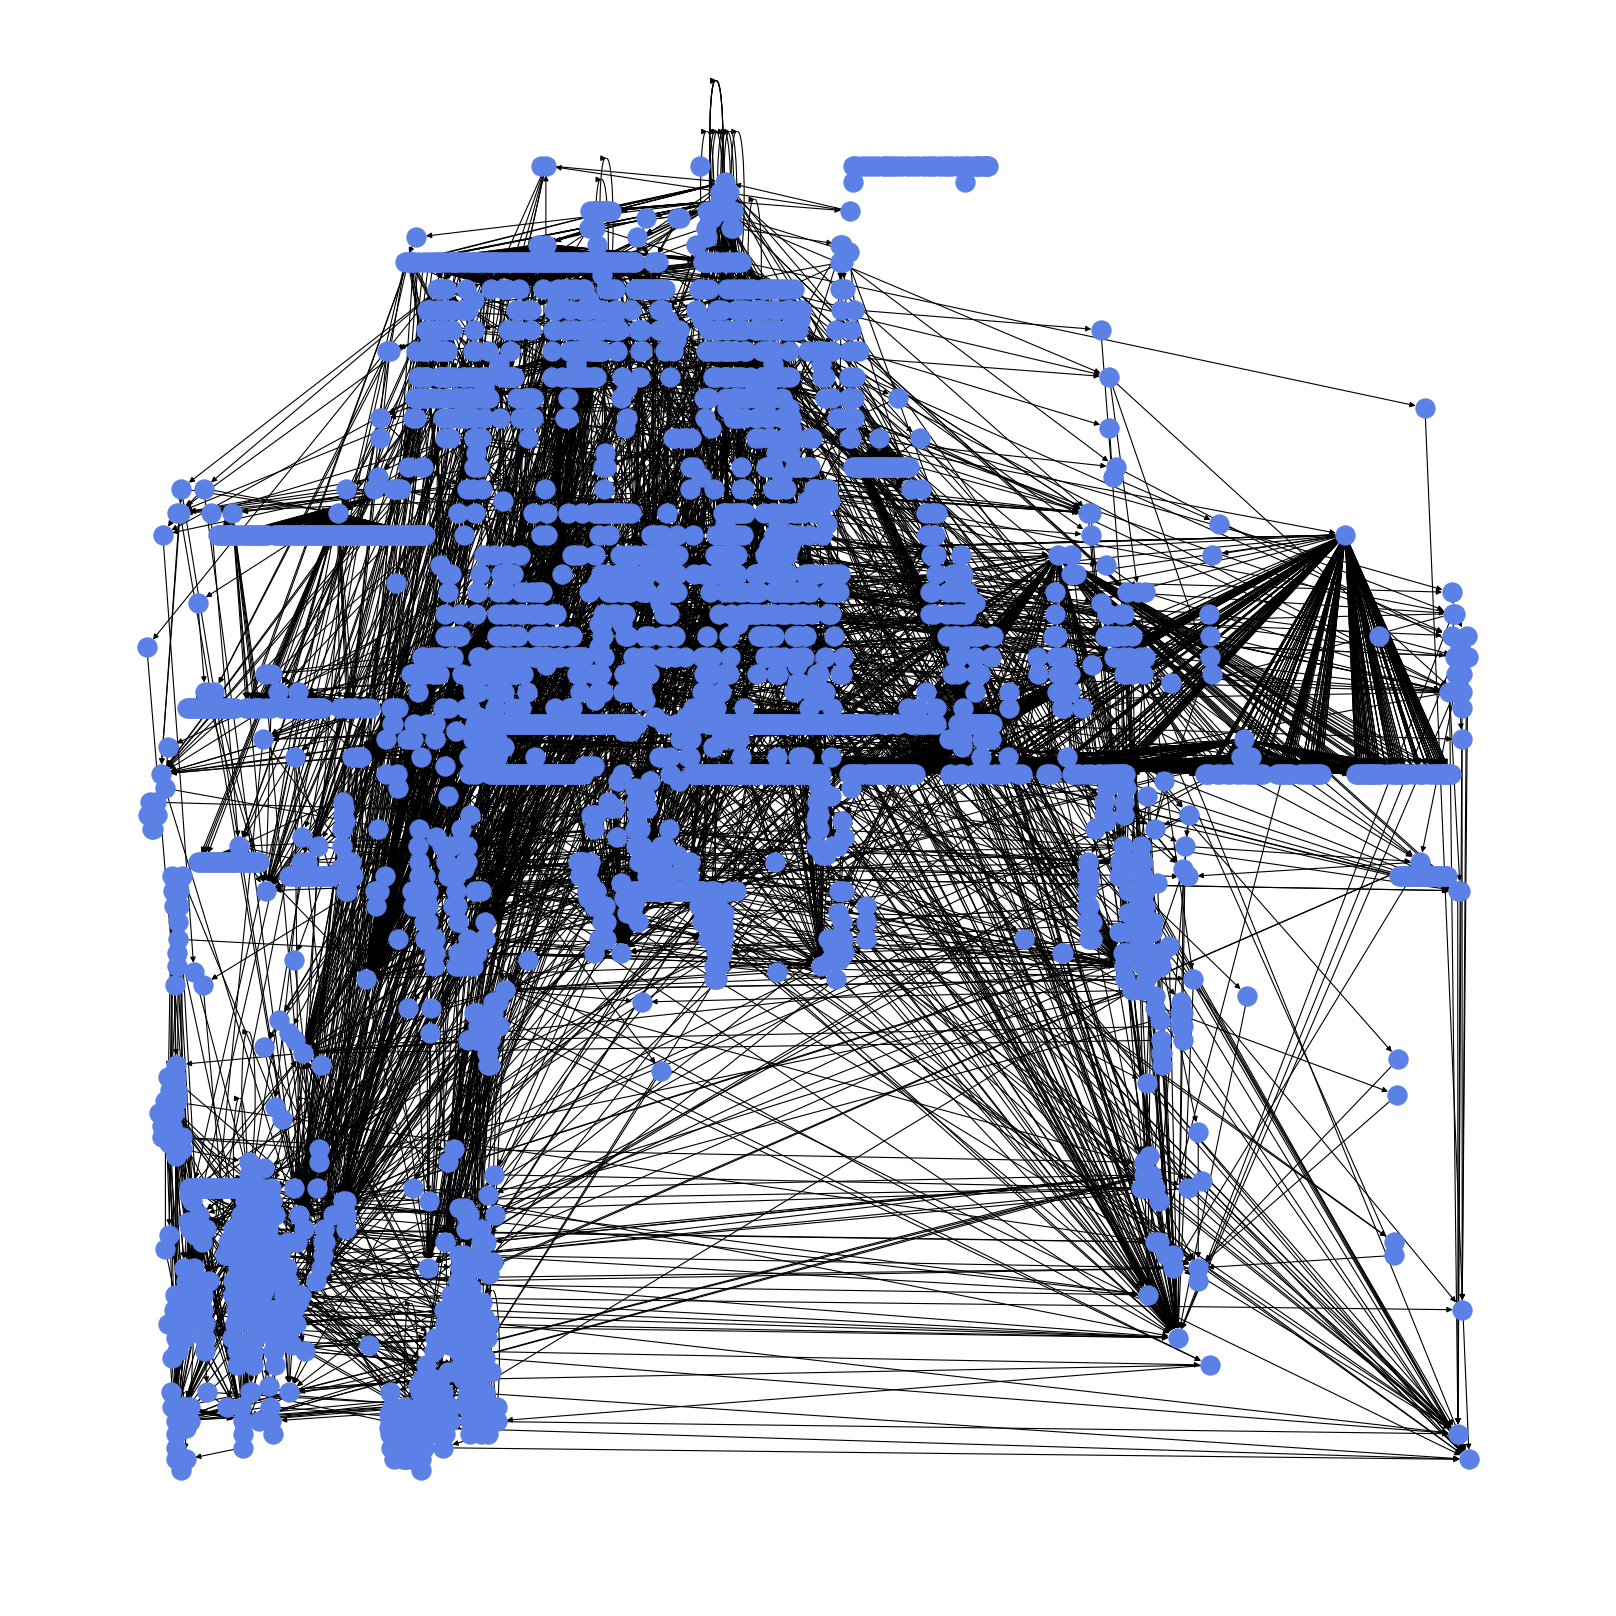

In [80]:
plt.figure(figsize=(20, 20), dpi=80)
nx.draw(full_graph, pos_full, arrows=True, node_color="#5c81e6")
plt.show()

#### Preprocessing

In [81]:
# Remove unstable nodes where dotfile name is same as db measurement
unstable_benchmarks_idx = []
for idx, graph in enumerate(final_graphs):
    if list(ordered_graphs.keys())[idx].rsplit("_", 1)[1] in unstable_benchmarks:
        print("Removing unstable benchmark", list(ordered_graphs.keys())[idx])
        unstable_benchmarks_idx.append(idx)

print(unstable_benchmarks_idx)

Removing unstable benchmark 07-14-2023_BenchmarkHeadPostingForMatchers-n="1",i=~".*",i!="2",j="foo"
Removing unstable benchmark 07-14-2023_BenchmarkRowsUnmarshal
Removing unstable benchmark 07-14-2023_BenchmarkHeadPostingForMatchers-n="1",i=~"1.+",j="foo"
Removing unstable benchmark 07-14-2023_BenchmarkHeadPostingForMatchers-i=~".*"
Removing unstable benchmark 07-14-2023_BenchmarkHeadPostingForMatchers-n="1",i=~".+",i!~"2.*",j="foo"
Removing unstable benchmark 07-14-2023_BenchmarkHeadPostingForMatchers-n="1",j!="foo"
Removing unstable benchmark 07-14-2023_BenchmarkHeadPostingForMatchers-n="1",i=~".+",j="foo"
Removing unstable benchmark 07-14-2023_BenchmarkHeadPostingForMatchers-n="1",i!="",j="foo"
Removing unstable benchmark 07-14-2023_BenchmarkHeadPostingForMatchers-n="1",i=~".+",i!="2",j="foo"
[54, 144, 189, 246, 272, 307, 320, 482, 491]


# Reduction Algorithm

Key error BenchmarkTableAddRows-tsidsCount_100-rowsPerInsert_10 BenchmarkTableAddRows-tsidsCount_1-rowsPerInsert_10
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Switched for more stable benchmark
Key error BenchmarkApplyRelabelConfigs-labelkeep-mismatch BenchmarkTableAddRows

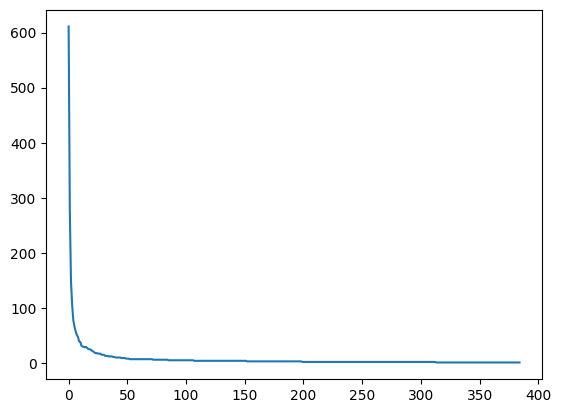

In [82]:
"""Take graphs with highest coverage and remove them from the remaining graphs."""
available_graphs = final_graphs.copy()
reduce_graphs_nodes = []
remaining_graph = full_graph.copy()
coverage_information = {}
iterations = 0
used_graph_idx = []

while len(remaining_graph.nodes()) > 1:
    
    # Find highest coverage within the unused benchmark graphs
    highest_coverage = (0, 0)
    
    for idx, benchmark_graph in enumerate(available_graphs):  

        if (idx in used_graph_idx) or (idx in unstable_benchmarks_idx): #or (idx in failed_benchs_idx):
            continue

        overlap_nodes = np.intersect1d(list(benchmark_graph.nodes()), list(remaining_graph.nodes()))
        overlap = len(overlap_nodes)

        if overlap == highest_coverage[1] and overlap > 0:
            name_curr = list(ordered_graphs.keys())[idx].split("_", 1)[1]
            name_highest = list(ordered_graphs.keys())[highest_coverage[0]].split("_", 1)[1]

            try:
                stability_curr = np.mean(stability_measures[name_curr])
                stability_high = np.mean(stability_measures[name_highest])
            except KeyError:
                print("Key error", name_curr, name_highest)
                continue
                        
            # print(f"Remaining: {len(remaining_graph.nodes())} - Overlap between {idx} and {highest_coverage[0]}: {overlap}, Stabilities: {stability_curr} {stability_high}")
            # Take the more stable benchmark

            if stability_curr < stability_high:
                print("Switched for more stable benchmark")
                highest_coverage = (idx, overlap)
            
        if overlap > highest_coverage[1]:
            highest_coverage = (idx, overlap)
        
        if iterations == 0:
            coverage_information[list(ordered_graphs.keys())[idx]] = overlap

    
    # if iterations % 20  == 0:
    #     plt.figure(figsize=(20, 20), dpi=80)
    #     color_map_full = ['blue' if node in remaining_graph.nodes()  else 'green' for node in full_graph.nodes()]
    #     nx.draw(full_graph, pos_full, with_labels=False, arrows=True, node_color=color_map_full)
    #     plt.show()

    if highest_coverage[1] == 0:
        print(f"Failed to find graph with overlap, Remaining: {len(remaining_graph.nodes())}")
        break
    
    reduce_graphs_nodes.append(highest_coverage)
    
    # remove graph from unused graphs and nodes from remaining graph
    used_graph = available_graphs[highest_coverage[0]].copy()
    used_graph_idx.append(highest_coverage[0])
    remaining_graph.remove_nodes_from(used_graph.nodes())
    iterations += 1

plt.plot([x[1] for x in reduce_graphs_nodes])
plt.show()

# Result Visualization

In [83]:
reduced_suite = [(x[0], list(ordered_graphs.keys())[x[0]].split('_', 1)[1]) for x in reduce_graphs_nodes]

In [85]:
notFound = 0
failed_benchs_idx = []
reduced_idx = [x[0] for x in reduce_graphs_nodes]
stabilities_new = []
stabilities_old = []
for idx, x in enumerate(final_graphs):
    try:
        selected_bench = list(ordered_graphs.keys())[idx]
        name = selected_bench.split('_', 1)[1]
        stability = np.mean(stability_measures[name])
        stabilities_old.append(stability)
        if idx in reduced_idx:
            stabilities_new.append(stability)
    except KeyError:
        notFound += 1
        failed_benchs_idx.append(idx)
        print(f"KeyError: {selected_bench} -> {name}")
print(f"KeyErrors: {notFound}")

KeyError: 07-14-2023_BenchmarkPartSearch-sparseness-2-tsids-1000 -> BenchmarkPartSearch-sparseness-2-tsids-1000
KeyError: 07-14-2023_BenchmarkPartSearch-sparseness-10-tsids-100 -> BenchmarkPartSearch-sparseness-10-tsids-100
KeyError: 07-14-2023_BenchmarkFastQueueThroughputConcurrent-block-size-100000 -> BenchmarkFastQueueThroughputConcurrent-block-size-100000
KeyError: 07-14-2023_BenchmarkAggregatorsPushByJobAvg-output=avg -> BenchmarkAggregatorsPushByJobAvg-output=avg
KeyError: 07-14-2023_BenchmarkFastQueueThroughputConcurrent-block-size-10 -> BenchmarkFastQueueThroughputConcurrent-block-size-10
KeyError: 07-14-2023_BenchmarkTableAddRows-tsidsCount_1000-rowsPerInsert_1000 -> BenchmarkTableAddRows-tsidsCount_1000-rowsPerInsert_1000
KeyError: 07-14-2023_BenchmarkFastQueueThroughputConcurrent-block-size-10000 -> BenchmarkFastQueueThroughputConcurrent-block-size-10000
KeyError: 07-14-2023_BenchmarkPartSearch-sparseness-100-tsids-1000 -> BenchmarkPartSearch-sparseness-100-tsids-1000
KeyErr

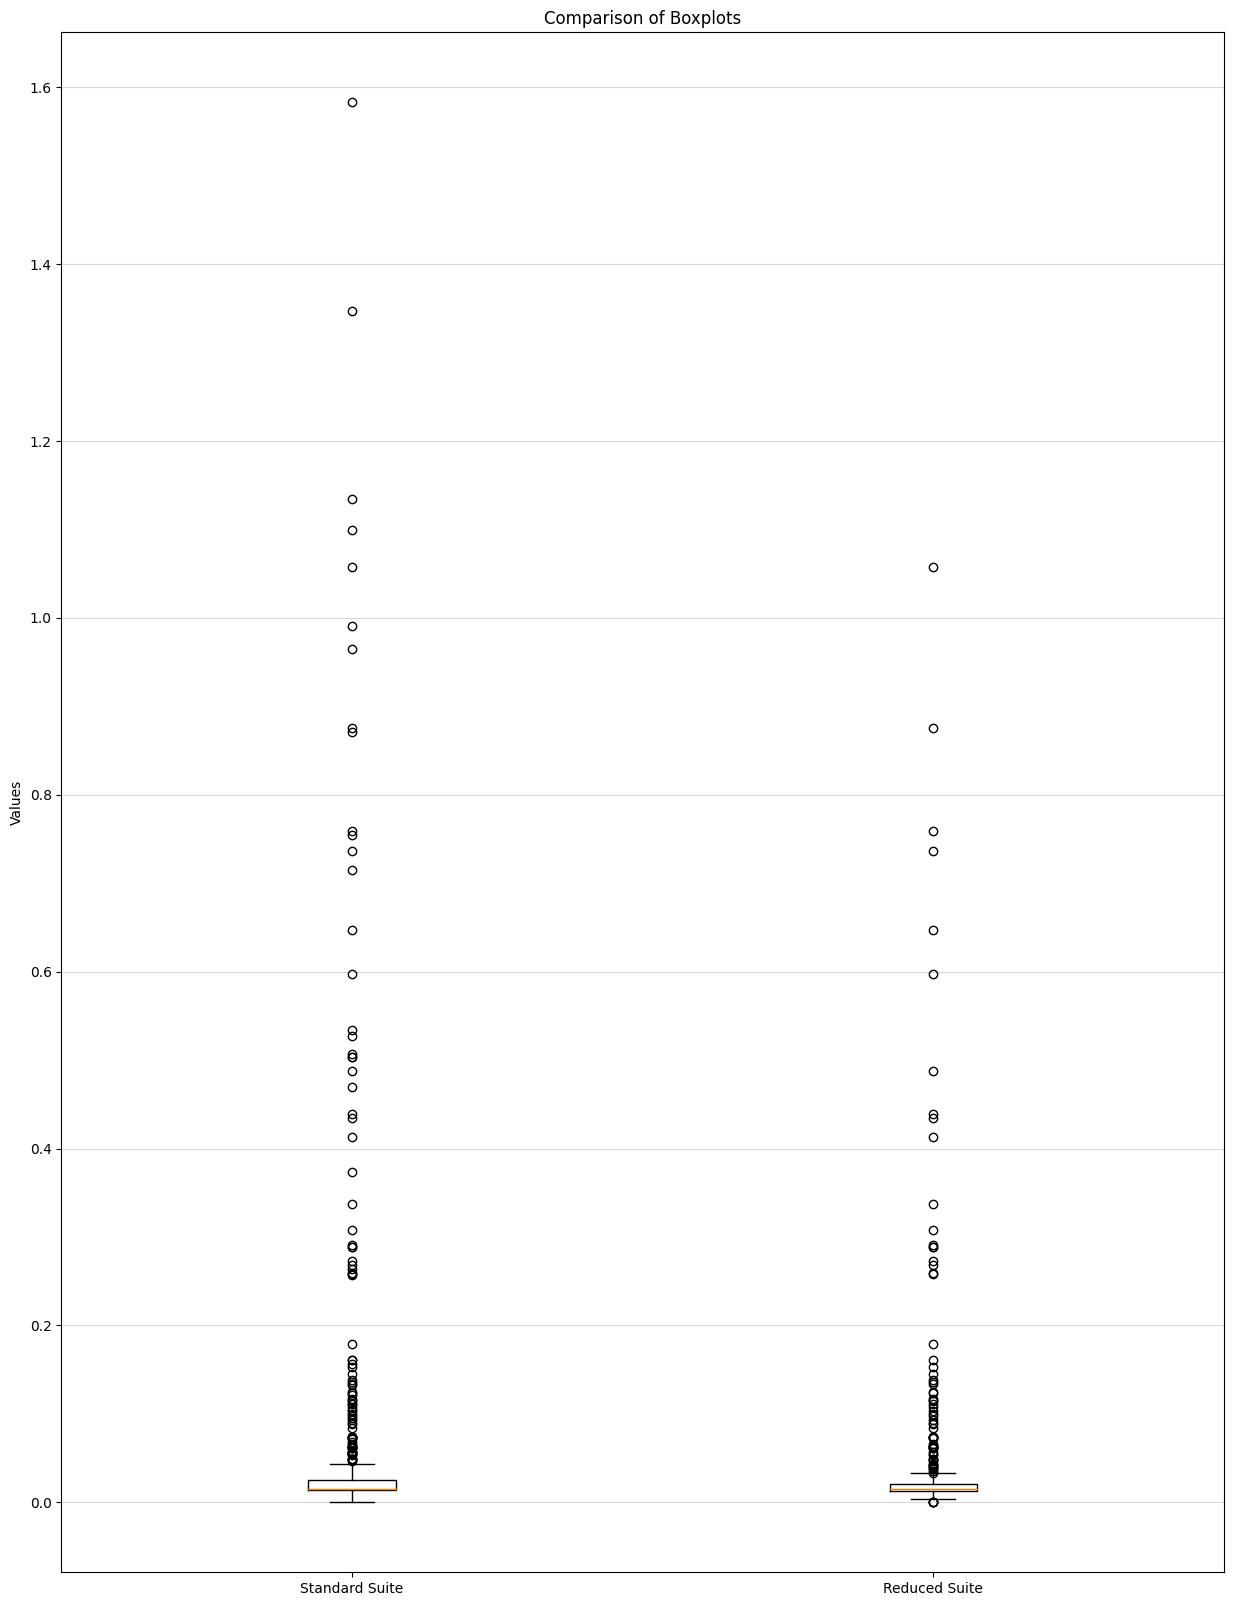

In [86]:
data = [stabilities_old, stabilities_new]

fig, ax = plt.subplots(figsize=(15, 20))
boxplot = ax.boxplot(data, positions=[1, 2], labels=['Standard Suite', 'Reduced Suite'])
ax.set_ylabel('Values')
ax.set_title('Comparison of Boxplots')
ax.grid(axis='y', alpha=0.50)

plt.show()

In [87]:
len(reduced_idx)

385

In [88]:
found_changes = []
found_name = []
reduced_idx = [x[0] for x in reduce_graphs_nodes]

for idx, x in enumerate(final_graphs):
    try:
        selected_bench = list(ordered_graphs.keys())[idx]
        name = selected_bench.split('_', 1)[1]
        if idx in reduced_idx:
            found_changes.append(perf_dict[name])
            found_name.append(name)
    except KeyError:
        notFound += 1
        failed_benchs_idx.append(idx)
        print(f"KeyError: {selected_bench} -> {name}")
print(f"KeyErrors: {notFound}")

KeyError: 07-14-2023_BenchmarkPromRegexMatchString-prefix-or-values-mismatch-PromRegex -> BenchmarkPromRegexMatchString-prefix-or-values-mismatch-PromRegex
KeyError: 07-14-2023_BenchmarkTableSearch-itemsCount-10000000-random-keys-without-suffix-rowsToScan-1 -> BenchmarkTableSearch-itemsCount-10000000-random-keys-without-suffix-rowsToScan-1
KeyError: 07-14-2023_BenchmarkOptimizedReMatchCost-.+middle.+ -> BenchmarkOptimizedReMatchCost-.+middle.+
KeyError: 07-14-2023_BenchmarkFilterHasHit-maxItems=1000 -> BenchmarkFilterHasHit-maxItems=1000
KeyError: 07-14-2023_BenchmarkRollupAvg -> BenchmarkRollupAvg
KeyError: 07-14-2023_BenchmarkApplyRelabelConfigs-labelkeep-match -> BenchmarkApplyRelabelConfigs-labelkeep-match
KeyError: 07-14-2023_BenchmarkTableSearch-itemsCount-1000000-random-keys-without-suffix-rowsToScan-100 -> BenchmarkTableSearch-itemsCount-1000000-random-keys-without-suffix-rowsToScan-100
KeyError: 07-14-2023_BenchmarkUnixTimestamp -> BenchmarkUnixTimestamp
KeyError: 07-14-2023_B

In [89]:
found_name

['BenchmarkApplyRelabelConfigs-labelmap-mismatch',
 'BenchmarkMatchRegexSingleValueMismatchUnoptimized',
 'BenchmarkHeadPostingForMatchers-n="1"',
 'BenchmarkQueueThroughputConcurrent-block-size-1',
 'BenchmarkHeadPostingForMatchers-j="foo",n="1"',
 'BenchmarkApplyRelabelConfigs-labelkeep-match-regexp',
 'BenchmarkCompressWriteRequestSnappy-s2-rows_1000',
 'BenchmarkUnmarshalInt64NearestDelta',
 'BenchmarkPromRegexMatchString-prefix-dot-star-mismatch-StandardRegex',
 'BenchmarkPromRegexMatchString-prefix-substring-dot-plus-match-StandardRegex',
 'BenchmarkMapHasHitRandomLastBits-lastBits_32',
 'BenchmarkTableSearch-itemsCount-10000000-random-keys-without-suffix-rowsToScan-1000',
 'BenchmarkCommonPrefixLen-prefix-len-0',
 'BenchmarkDeduplicateSamples-minScrapeInterval=2s',
 'BenchmarkPromRegexMatchString-unpotimized-prefix-mismatch-PromRegex',
 'BenchmarkTableSearch-itemsCount-1000000-sequential-keys-without-suffix-rowsToScan-1000',
 'BenchmarkTableSearch-itemsCount-1000000-sequential-k

In [90]:
for idx, x in enumerate(found_name):
    print(perf_dict[x], x)

2.560724869791553 BenchmarkApplyRelabelConfigs-labelmap-mismatch
0.5437206109971671 BenchmarkMatchRegexSingleValueMismatchUnoptimized
0.10762402982121833 BenchmarkHeadPostingForMatchers-n="1"
0.3634964559054765 BenchmarkQueueThroughputConcurrent-block-size-1
0.5393035285052417 BenchmarkHeadPostingForMatchers-j="foo",n="1"
4.075715869948593 BenchmarkApplyRelabelConfigs-labelkeep-match-regexp
1.0735612035746356 BenchmarkCompressWriteRequestSnappy-s2-rows_1000
0.015035202291757699 BenchmarkUnmarshalInt64NearestDelta
4.907494682454249 BenchmarkPromRegexMatchString-prefix-dot-star-mismatch-StandardRegex
0.3031842169879617 BenchmarkPromRegexMatchString-prefix-substring-dot-plus-match-StandardRegex
2.5578127624699354 BenchmarkMapHasHitRandomLastBits-lastBits_32
1.0431431442582406 BenchmarkTableSearch-itemsCount-10000000-random-keys-without-suffix-rowsToScan-1000
1.48504657666515 BenchmarkCommonPrefixLen-prefix-len-0
0.20805420734395508 BenchmarkDeduplicateSamples-minScrapeInterval=2s
38.51502

In [91]:
print(len(found_changes))
print(len(perf_dict.keys()))

74
108


In [92]:
not_found = []
for change_b in perf_dict.keys():
    if change_b not in found_name:
        not_found.append(change_b)

print(len(not_found))
not_found

34


['BenchmarkCommonPrefixLen-prefix-len-127',
 'BenchmarkFilterHasMiss-maxItems=1000000',
 'BenchmarkMapAddWithAllocs-items_100000',
 'BenchmarkOptimizedReMatchCost-.+',
 'BenchmarkMarshalInt64NearestDelta2-precisionBits_4',
 'BenchmarkAddMulti-items_100000',
 'BenchmarkPromRegexMatchString-dot-plus-mismatch-PromRegex',
 'BenchmarkSetAddWithAllocs-items_1000',
 'BenchmarkUnionNoOverlap-items_100000',
 'BenchmarkMapAddReuse-items_10000000',
 'BenchmarkFilterHasHit-maxItems=10000',
 'BenchmarkMapAddNoAllocs-items_1000000',
 'BenchmarkFilterHasHit-maxItems=100000',
 'BenchmarkMapHasMiss-items_10000',
 'BenchmarkUnionFullOverlap-items_1000',
 'BenchmarkMapHasHit-items_1000',
 'BenchmarkMapAddNoAllocs-items_10000000',
 'BenchmarkReaderAtMustReadAt-mmap_off-1000',
 'BenchmarkMapAddRandomLastBits-lastBits_24',
 'BenchmarkPromRegexMatchString-substring-dot-star-match-StandardRegex',
 'BenchmarkFromFloat-0',
 'BenchmarkMergeSortBlocks-replicationFactor-2',
 'BenchmarkMapAddReuse-items_1000000',
 

In [96]:
# Check if graphs overlap with reduced suite
newly_found = set()
for change in not_found:
    for idx, graph in enumerate(final_graphs):
        if list(ordered_graphs.keys())[idx].split("_", 1)[1] == change:
            graph = final_graphs[idx]

            highest_overlap = (0, 0)
            for selected in reduced_suite:
                name = selected[1]
                selected_graph = final_graphs[selected[0]]
                overlap_nodes = np.intersect1d(list(graph.nodes()), list(selected_graph.nodes()))

                # calculate percentage of overlap with graph
                overlap_percentage = len(overlap_nodes) / len(graph.nodes())
                if overlap_percentage > 0.8 and overlap_percentage > highest_overlap[1]:
                    highest_overlap = (selected, overlap_percentage)
                
            if highest_overlap[1] > 0:  
                selected = highest_overlap[0]
                name = selected[1]
                selected_graph = final_graphs[selected[0]]

                # calculate missing nodes
                missing_nodes = np.setdiff1d(list(graph.nodes()), list(selected_graph.nodes()))

                if highest_overlap[1] < 1.0 and False:
                    for selected in reduced_suite:
                        name1 = selected[1]
                        selected_graph = final_graphs[selected[0]]
                        overlap_nodes = np.intersect1d(missing_nodes, list(selected_graph.nodes()))

                        # calculate percentage of overlap with graph
                        overlap_percentage = len(overlap_nodes) / len(graph.nodes())
                        if overlap_percentage > 0.5:
                            print(f"Missing nodes: {len(missing_nodes)} - Overlap: {overlap_percentage}")
                        if overlap_percentage == 1.0:
                            print(f"Missing benchmark {change} overlaps with {name} and {name1}")
                            newly_found.add(change)
                else:       
                    print(f"Missing benchmark {change} overlaps with {name}: {highest_overlap[1]} - Missing nodes: {len(missing_nodes)}")
                    newly_found.add(change)

                # Plot graphs
                # plt.figure(figsize=(10, 10), dpi=80)
                # pos_full2 = {k: (v[0] + 100, v[1]) for k, v in pos_full.items()}
                # nx.draw(selected_graph, pos_full, arrows=True, node_color="blue")
                # nx.draw(graph, pos_full2, arrows=True, node_color="red")
                # plt.show()

Missing benchmark BenchmarkCommonPrefixLen-prefix-len-127 overlaps with BenchmarkTableSearch-itemsCount-1000000-random-keys-without-suffix-rowsToScan-1: 0.9333333333333333 - Missing nodes: 1
Missing benchmark BenchmarkMapAddWithAllocs-items_100000 overlaps with BenchmarkMapAddWithAllocs-items_10000: 0.8596491228070176 - Missing nodes: 24
Missing benchmark BenchmarkOptimizedReMatchCost-.+ overlaps with BenchmarkTableSearch-itemsCount-10000000-random-keys-without-suffix-rowsToScan-10: 0.9090909090909091 - Missing nodes: 3
Missing benchmark BenchmarkMarshalInt64NearestDelta2-precisionBits_4 overlaps with BenchmarkTableSearch-rowsCount_100000000-tsidsCount_10000-tsidsSearch_10: 0.8947368421052632 - Missing nodes: 2
Missing benchmark BenchmarkAddMulti-items_100000 overlaps with BenchmarkAddMulti-items_1000: 0.9560439560439561 - Missing nodes: 4
Missing benchmark BenchmarkPromRegexMatchString-dot-plus-mismatch-PromRegex overlaps with BenchmarkPromRegexMatchString-unpotimized-noprefix-mismatc

In [93]:
import re

def recalculate_percentages_based_on_seconds(graph):
    # extract seconds x.xxs using regex
    r = re.compile(r"(\d+\.\d+|\d)s")

    total_time = 0
    for node in graph.nodes(data=True):
        try:
            seconds = r.search(node[1]['label']).group(1)
            total_time += float(seconds)
        except AttributeError:
            print(f"There was an error extracting seconds from {node[1]['label']}")
            continue

    # recalculate percentages
    for node in graph.nodes(data=True):
        try:
            seconds = float(r.search(node[1]['label']).group(1))
        except AttributeError:
            print(f"There was an error extracting seconds from {node[1]['label']}")
            continue

        # calculate percentage of total time
        percentage = seconds / total_time * 100
        node[1]['totalPerc'] = percentage


# check if first graph overlaps graph 2 sufficeintly
def calculate_overlap_value(graph1, graph2):

    # Calculate percentages based on total seconds of reduced graph
    recalculate_percentages_based_on_seconds(graph1)
    recalculate_percentages_based_on_seconds(graph2)

    perc = 0
    for node in graph2.nodes(data=True):
        if node[0] in graph1.nodes():
            # print(f"Found {node[1]['label']} with {node[1]['totalPerc']}")
            perc += node[1]['totalPerc']
    return perc / 100

In [95]:
# Check if graphs overlap with reduced suite with new overlap method
matching_graphs = []
newly_found = set()
for change in not_found:
    for idx, graph in enumerate(final_graphs):
        if list(ordered_graphs.keys())[idx].split("_", 1)[1] == change:
            graph = final_graphs[idx]

            highest_overlap = (0, 0)
            for selected in reduced_suite:
                name = selected[1]
                selected_graph = final_graphs[selected[0]]
                overlap_percentage = calculate_overlap_value(selected_graph, graph)

                if overlap_percentage > 0.95 and overlap_percentage > highest_overlap[1]:
                    highest_overlap = (selected, overlap_percentage)
            
            if highest_overlap[1] > 0:  
                selected = highest_overlap[0]
                name = selected[1]
                selected_graph = final_graphs[selected[0]]
            
                print(f"Missing benchmark {change} overlaps with {name}: {highest_overlap[1]}")
                newly_found.add(change)
                matching_graphs.append((selected_graph, graph))

There was an error extracting seconds from promrelabel\n(*graphiteMatchTemplate)\nMatch\n6040ms (39.76%)\nof 14000ms (92.17%)
There was an error extracting seconds from testing\n(*B)\nRunParallel\nfunc1\n0 of 15190ms (100%)
There was an error extracting seconds from promrelabel\nbenchmarkGraphiteMatchTemplateMatch\nfunc1\n810ms (5.33%)\nof 15190ms (100%)
There was an error extracting seconds from strings\nIndex\n1590ms (10.47%)\nof 3890ms (25.61%)
There was an error extracting seconds from strings\nHasSuffix\n990ms (6.52%)\nof 2140ms (14.09%)
There was an error extracting seconds from strings\nIndexByte\n370ms (2.44%)\nof 1930ms (12.71%)
There was an error extracting seconds from bytealg\nIndexString\n600ms (3.95%)
There was an error extracting seconds from testing\n(*PB)\nNext\n380ms (2.50%)
There was an error extracting seconds from runtime\nmemequal\n220ms (1.45%)
There was an error extracting seconds from bytealg\nIndexByteString\n290ms (1.91%)
There was an error extracting seconds

KeyError: 'totalPerc'

In [97]:
print(len(newly_found))
newly_found

29


{'BenchmarkAddMulti-items_100000',
 'BenchmarkAddMulti-items_1000000',
 'BenchmarkAppendFloatToDecimal-Integers',
 'BenchmarkCommonPrefixLen-prefix-len-127',
 'BenchmarkCommonPrefixLen-prefix-len-2',
 'BenchmarkCommonPrefixLen-prefix-len-8',
 'BenchmarkCompressWriteRequestSnappy-s2-rows_10000',
 'BenchmarkDeduplicateSamplesDuringMerge-minScrapeInterval=5s',
 'BenchmarkFilterHasHit-maxItems=10000',
 'BenchmarkFilterHasHit-maxItems=100000',
 'BenchmarkFromFloat-0',
 'BenchmarkFromFloat-1234',
 'BenchmarkMapAddNoAllocs-items_1000000',
 'BenchmarkMapAddNoAllocs-items_10000000',
 'BenchmarkMapAddRandomLastBits-lastBits_24',
 'BenchmarkMapAddReuse-items_1000000',
 'BenchmarkMapAddWithAllocs-items_100000',
 'BenchmarkMapHasHit-items_1000',
 'BenchmarkMapHasMiss-items_10000',
 'BenchmarkMarshalInt64NearestDelta2-precisionBits_4',
 'BenchmarkMarshalVarInt64s-up-to-(1<<13)-1',
 'BenchmarkOptimizedReMatchCost-.+',
 'BenchmarkPromRegexMatchString-dot-plus-mismatch-PromRegex',
 'BenchmarkPromRegexM

In [117]:
len(not_found) - len(newly_found)

0

# Visualize matches

In [126]:
graphs = matching_graphs[-4]

In [129]:
labeldict1 = labeldict.copy()
# remove all nodes not in test_graph
for key in labeldict:
    if key not in graphs[0].nodes():
        del labeldict1[key]

labeldict2 = labeldict.copy()
# remove all nodes not in test_graph
for key in labeldict:
    if key not in graphs[1].nodes():
        del labeldict2[key]

In [162]:
# how to generate gradient color values based on percentage
sum = 0
colors1 = []
for node in list(graphs[1].nodes(data=True)):
    percentage = node[1]['totalPerc'] / 100
    # percentage = round(percentage, 3)

    sum = sum + percentage

    color = (int(255 * percentage), int(255 * (1 - percentage)), 0)
    color = '#%02x%02x%02x' % color
    if node[0] not in list(graphs[0].nodes()):
        colors1.append("red")
        labeldict2[node[0]] = percentage
    else:
        colors1.append(color)
        labeldict2[node[0]] = ""

    # labeldict2[node[0]] = percentage

print(sum)

0.9999999999999979


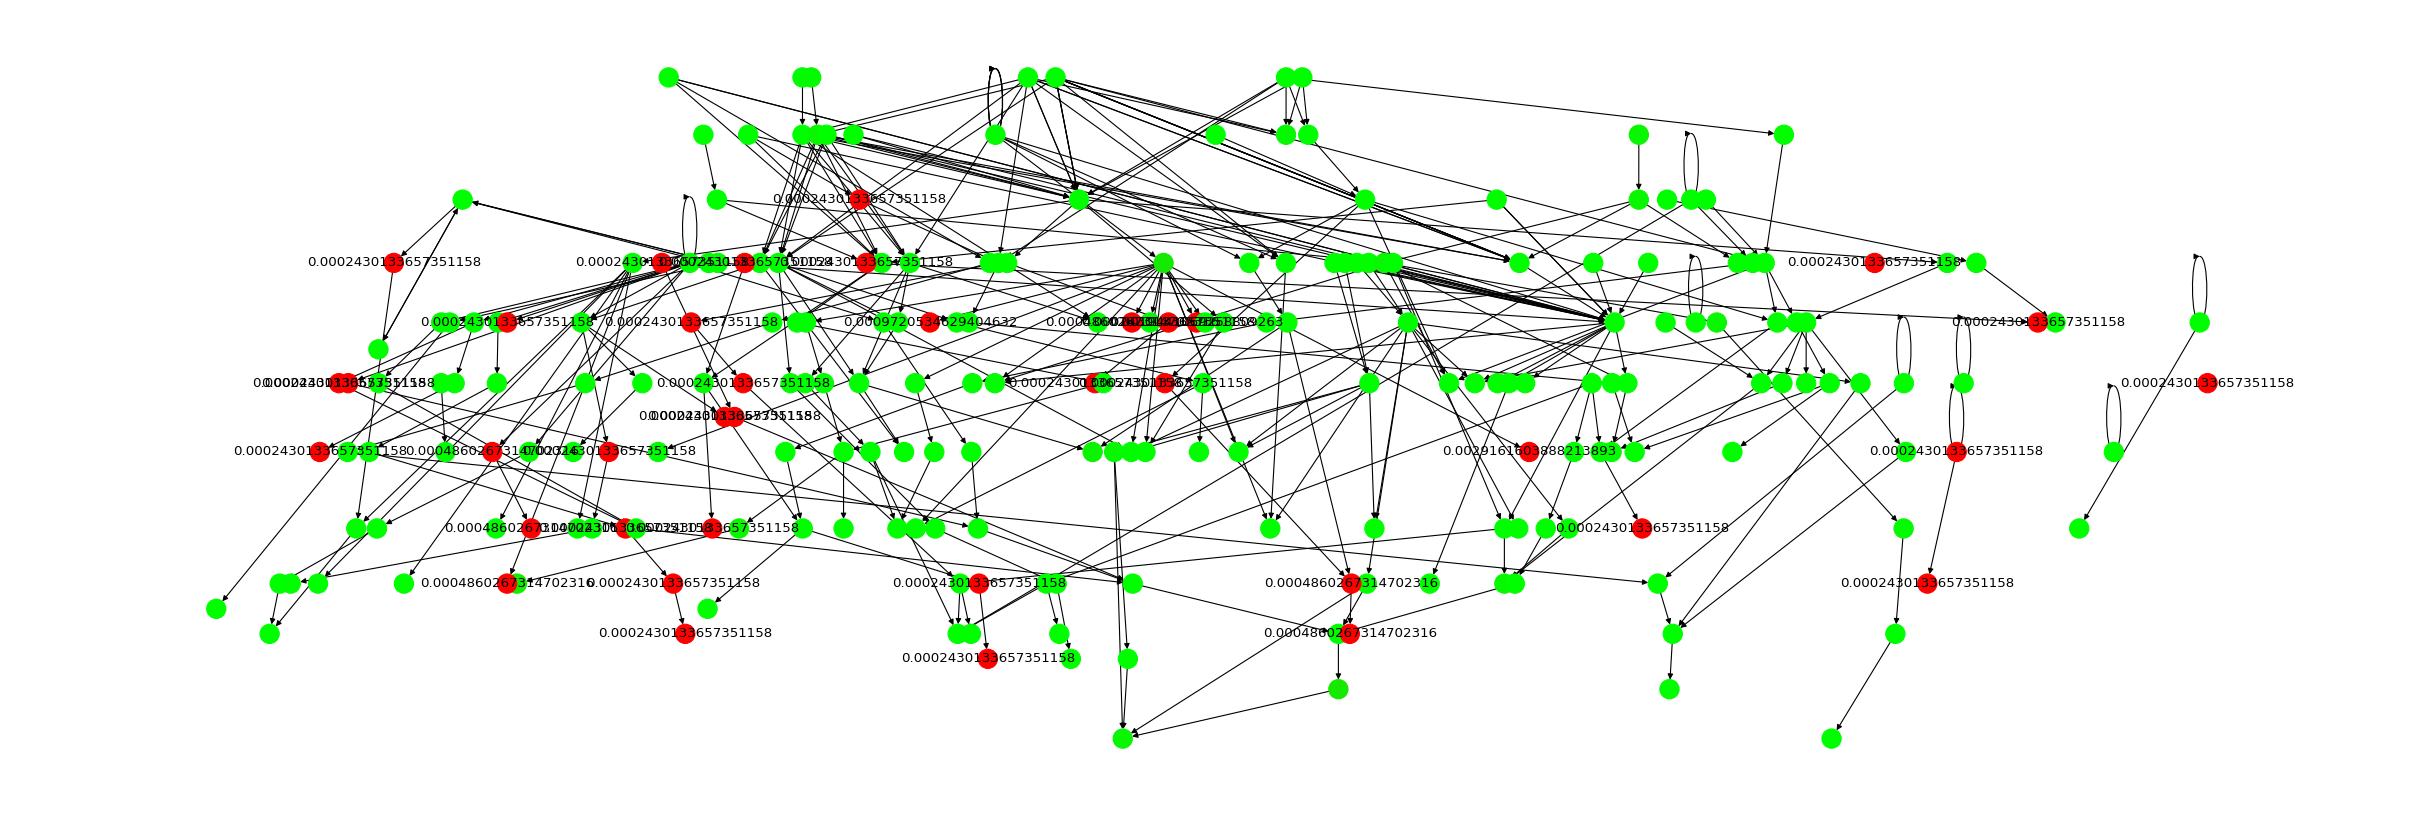

In [163]:
# plot graph with labels
plt.figure(figsize=(30, 10), dpi=80)

# shift pos full
pos_full2 = {k: (v[0] + 200, v[1]) for k, v in pos_full.items()}

# nx.draw(graphs[0], pos_full, arrows=True, node_color="green")
nx.draw(graphs[1], pos_full2, arrows=True, node_color=colors1, labels=labeldict2)
plt.show()

# Time saved

In [164]:
print("Old suite runtime in minutes:", len(final_graphs) * 5 * 3 * 1 / 60)
print("Reduced Suite runtime in minute:", len(reduced_idx) * 5 * 3 * 1 / 60)

Old suite runtime in minutes: 51.75
Reduced Suite runtime in minute: 20.5


[(<networkx.classes.multidigraph.MultiDiGraph at 0x1735f0a10>,
  <networkx.classes.multidigraph.MultiDiGraph at 0x2829b6950>),
 (<networkx.classes.multidigraph.MultiDiGraph at 0x28cc5a010>,
  <networkx.classes.multidigraph.MultiDiGraph at 0x176cc4550>),
 (<networkx.classes.multidigraph.MultiDiGraph at 0x28cc5a010>,
  <networkx.classes.multidigraph.MultiDiGraph at 0x28cc78b90>),
 (<networkx.classes.multidigraph.MultiDiGraph at 0x1748e2ad0>,
  <networkx.classes.multidigraph.MultiDiGraph at 0x173579690>),
 (<networkx.classes.multidigraph.MultiDiGraph at 0x2873e12d0>,
  <networkx.classes.multidigraph.MultiDiGraph at 0x28b9e1010>),
 (<networkx.classes.multidigraph.MultiDiGraph at 0x283a37490>,
  <networkx.classes.multidigraph.MultiDiGraph at 0x28e0c5b10>),
 (<networkx.classes.multidigraph.MultiDiGraph at 0x175c7f090>,
  <networkx.classes.multidigraph.MultiDiGraph at 0x28733b610>),
 (<networkx.classes.multidigraph.MultiDiGraph at 0x176d144d0>,
  <networkx.classes.multidigraph.MultiDiGraph at